In [25]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from architecture.classifier import DeepBinaryClassifier
from architecture.nodes.lut import make_lut_node
from architecture.utils import describe_architecture

In [26]:
dataset_df = pd.read_csv("./data/10_bit_artificial/107.csv")
input_values = dataset_df.drop(columns="class").to_numpy(bool)
target_values = dataset_df["class"].to_numpy(bool)

# balance
pos_idx = np.where(target_values == 1)[0]
neg_idx = np.where(target_values == 0)[0]

num_samples = min(len(pos_idx), len(neg_idx))

balanced_pos_idx = resample(pos_idx, n_samples=num_samples, replace=False, random_state=42)
balanced_neg_idx = resample(neg_idx, n_samples=num_samples, replace=False, random_state=42)

balanced_idx = np.concatenate([balanced_pos_idx, balanced_neg_idx])
input_values, target_values = input_values[balanced_idx], target_values[balanced_idx]

# split
input_values_train, input_values_test, target_values_train, target_values_test \
    = train_test_split(input_values, target_values, test_size=0.2, random_state=42, stratify=target_values)

print("Dataset shapes:")
print(f"TRAIN | input: {input_values_train.shape}, target: {target_values_train.shape}, pos. frac.: {target_values_train.mean():.3f}")
print(f"TEST  | input: {input_values_test.shape}, target: {target_values_test.shape}, pos. frac.: {target_values_test.mean():.3f}")

Dataset shapes:
TRAIN | input: (627, 10), target: (627,), pos. frac.: 0.501
TEST  | input: (157, 10), target: (157,), pos. frac.: 0.497


In [27]:
layer_node_counts = [8] * 3 + [1]
config = dict(layer_node_counts=layer_node_counts, layer_bit_counts=[4]*len(layer_node_counts), seed=42)

# the lut version gets slowed down by the multithreading overhead, so we use a single job here
net = DeepBinaryClassifier(**config, node_factory=make_lut_node)
%time net.fit(input_values_train, target_values_train)

pred_values_test = net.predict(input_values_test)
accuracies_test = (pred_values_test == target_values_test).mean(axis=0)

pred_values_test = net.predict(input_values_test)  # shape (N, 1)
accuracies_test = (pred_values_test == target_values_test).mean(axis=0)
print("Pre-reduction accuracy:", accuracies_test)

CPU times: user 3.32 ms, sys: 2.49 ms, total: 5.81 ms
Wall time: 4.18 ms
Pre-reduction accuracy: 0.7961783439490446


In [28]:
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "font.family": "DejaVu Sans",
    "font.weight": "bold"
})

def format_subscripts(name: str) -> str:
    """Format digits in names as subscripts (e.g. L2N7 -> $N_{7}$)."""
    return "$" + re.sub(r"([A-Za-z]+)(\d+)", r"\1_{\2}", name) + "$"

def plot_architecture_networkx(
        desc,
        *,
        layer_separation: float = 3.2,
        node_separation: float = 1.35,
        node_font_size: float = 12.0,
        header_font_size: float = 14.0,
        edge_width: float = 1.6,
        dpi: int = 120
):
    layers = desc["layers"]

    graph = nx.DiGraph()
    node_positions, node_labels = {}, {}
    for layer_idx, layer in enumerate(layers):
        node_names = [node["name"] for node in layer["nodes"]]
        num_nodes = len(node_names)

        node_y_positions = (np.arange(num_nodes)[::-1] - (num_nodes - 1) / 2.0) * node_separation
        node_x_positions = np.full(num_nodes, layer_idx * layer_separation)

        for node_idx, node_name in enumerate(node_names):
            node_positions[node_name] = (node_x_positions[node_idx], node_y_positions[node_idx])

            node_label = "N" + node_name.split("N", 1)[1]
            node_labels[node_name] = format_subscripts(node_label)

            for node_backlinks in layer["nodes"][node_idx].get("backlinks", []):
                if node_backlinks in node_positions:
                    graph.add_edge(node_backlinks, node_name)

    graph.add_nodes_from(node_positions)

    # layout and plot
    node_area = (node_font_size * 2.4) ** 2
    x_padding = 0.6 * layer_separation
    y_padding = 0.8 * node_separation
    header_offset = 0.6 * node_separation

    num_layers = max(1, len(layers))
    node_y_positions = [pos[1] for pos in node_positions.values()] or [0.0]
    node_y_min, node_y_max = min(node_y_positions), max(node_y_positions)
    node_x_min, node_x_max = -x_padding, (num_layers - 1) * layer_separation + x_padding
    node_y_min, node_y_max = node_y_min - y_padding, node_y_max + y_padding + header_offset

    figsize = ((node_x_max - node_x_min) * 0.90, (node_y_max - node_y_min) * 0.86)
    face_color = "white"
    draw_color = "black"

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_facecolor(face_color)

    nx.draw_networkx_edges(graph, node_positions, width=edge_width, edge_color=draw_color, arrows=False, ax=ax, alpha=0.95)
    nx.draw_networkx_nodes(graph, node_positions, node_size=node_area, node_color=face_color, edgecolors=draw_color, linewidths=edge_width, ax=ax)
    nx.draw_networkx_labels(graph, node_positions, labels=node_labels, font_size=node_font_size, font_weight="bold", font_color=draw_color, ax=ax)

    ax.set_xlim(node_x_min, node_x_max)
    ax.set_ylim(node_y_min, node_y_max)
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    # headers
    layer_titles = [format_subscripts(layer["name"]) for layer in layers]
    header_y_position = max(node_y_positions) + y_padding * 0.4 + header_offset

    for layer_idx, title in enumerate(layer_titles):
        header_x_position = layer_idx * layer_separation
        ax.text(header_x_position, header_y_position, title, ha="center", va="bottom", color=draw_color, fontweight="bold", fontsize=header_font_size)

    return fig, ax

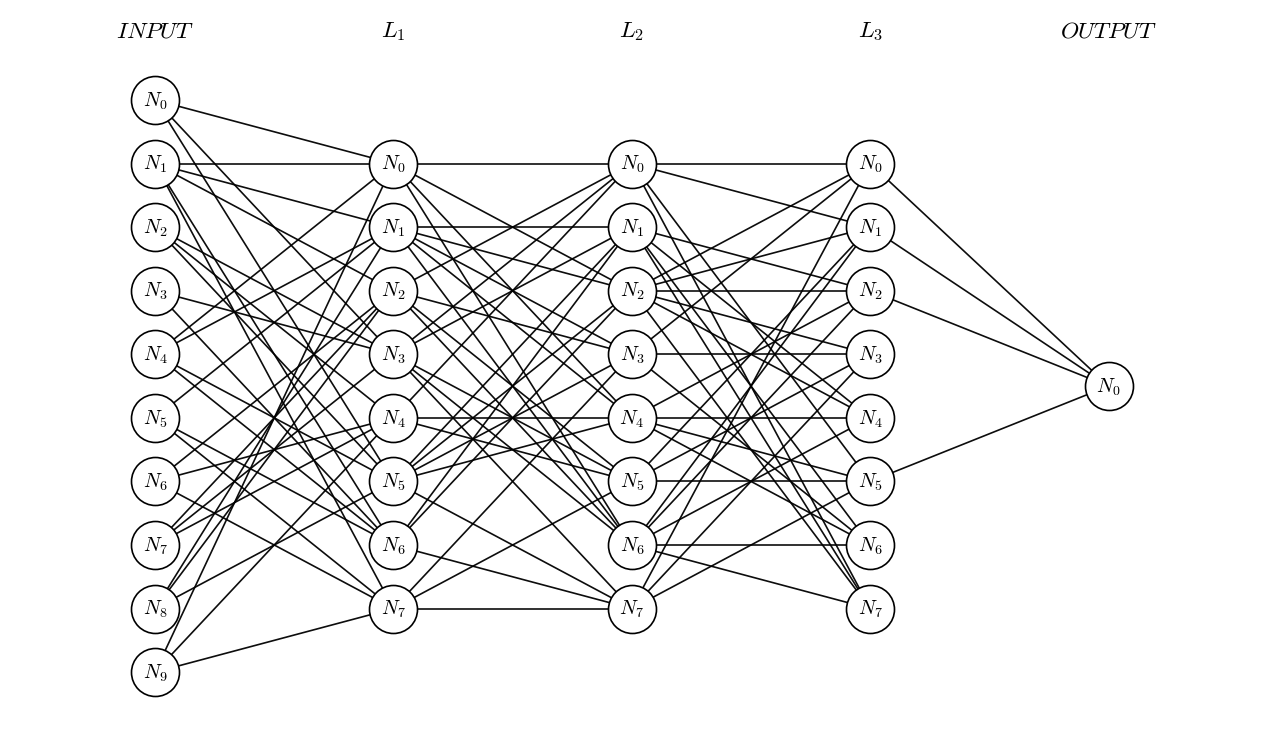

In [29]:
desc = describe_architecture(net)

fig, _ = plot_architecture_networkx(
    desc,
    layer_separation=3,
    node_separation=0.8,
    header_font_size = 14.0,
    edge_width=1,
)

In [30]:
fig.savefig("./figures/lut_raw_architecture.png", dpi=300, bbox_inches="tight")

In [20]:
net.prune()

pred_values_test = net.predict(input_values_test)  # shape (N, 1)
accuracies_test = (pred_values_test == target_values_test).mean(axis=0)
print("Post-reduction accuracy:", accuracies_test)

Post-reduction accuracy: 0.7961783439490446


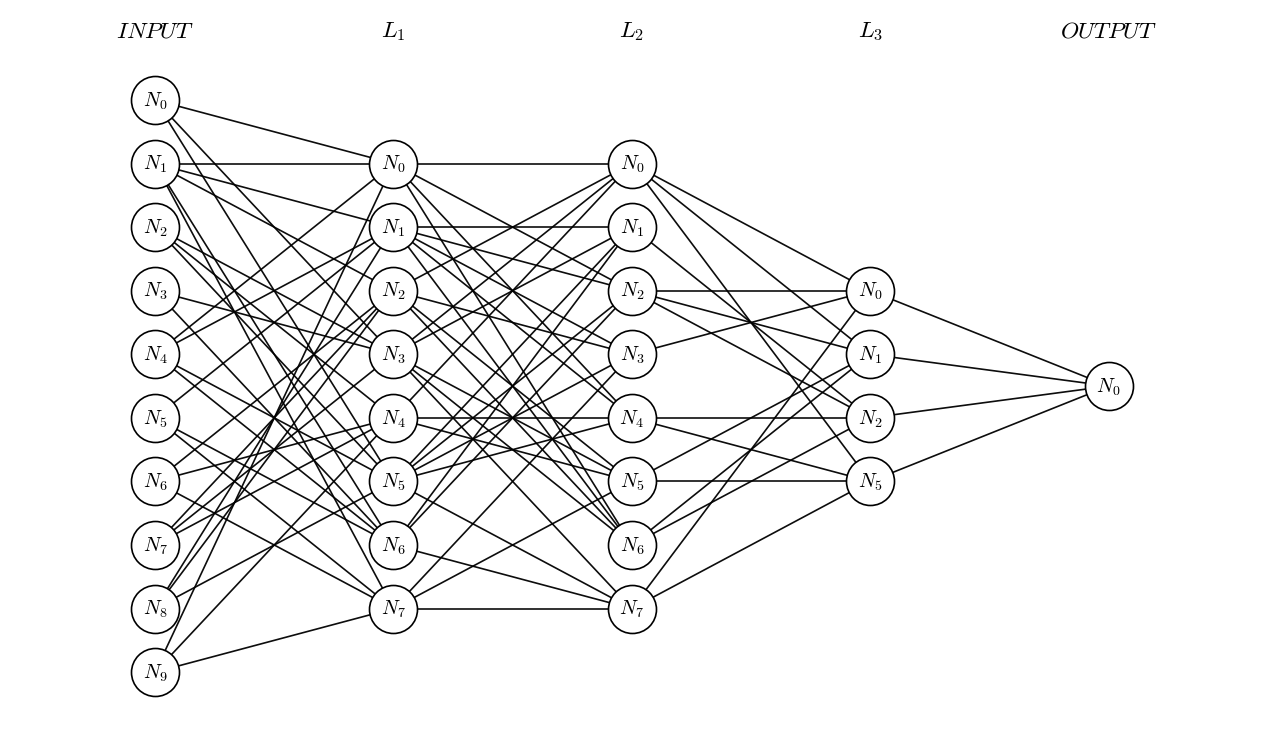

In [23]:
desc = describe_architecture(net)

fig, _ = plot_architecture_networkx(
    desc,
    layer_separation=3,
    node_separation=0.8,
    header_font_size = 14.0,
    edge_width=1,
)

In [24]:
fig.savefig("./figures/lut_pruned_architecture.png", dpi=300, bbox_inches="tight")